In [13]:
import requests
import os

# These values are used for retrieving a token and can be found in the
# API documentation at https://app.solarperformanceinsight.org/api/docs
TOKEN_ENDPOINT = "https://solarperformanceinsight.us.auth0.com/oauth/token"
AUDIENCE = "https://app.solarperformanceinsight.org/api"
CLIENT_ID = "G7Cag1LvitX0sOUOrYz03xv6xyl3bE9s"

# Here we're retrieving the username and password from environment
# variables to keep this script generic. Hard code them at your own
# risk.
USERNAME = os.getenv("SPI_USERNAME")
PASSWORD = os.getenv("SPI_PASSWORD")

In [14]:
# Request API Access token for the Solar Performance Insight api. The JSON response
# will contain the token in the 'access_token' field and a time until token expiration
# in seconds in the 'expires_in' field.
# 
# This token is passed in the 'Authorization' HTTP header when making requests to the
# Solar Performance Insight API by setting the header to: `Bearer {token}`
response = requests.post(
    TOKEN_ENDPOINT,
    data={
        "audience": AUDIENCE,
        "grant_type": "password",
        "username": USERNAME,
        "password": PASSWORD,
        "client_id": CLIENT_ID
    },
)
token = response.json()["access_token"]

In [15]:
# Defines a PV System Model located at the University of Arizona.
# The expected form of this system definition can be found in the API documentation
# here : https://app.solarperformanceinsight.org/api/docs#model-PVSystem

system = {
  "name": "Tucson System",
  "latitude": 32.2,
  "longitude": -110.9,
  "elevation": 777.63,
  # The system includes a single Inverter with a Single array.
  "inverters": [
    {
      "name": "Inverter 1",
      "make_model": "",
      "inverter_parameters": {
        "pdc0": 12000,
        "eta_inv_nom": 0.96,
        "eta_inv_ref": 0.9637
      },
      "losses": {
        "soiling": 2,
        "shading": 3,
        "snow": 0,
        "mismatch": 2,
        "wiring": 2,
        "connections": 0.5,
        "lid": 1.5,
        "nameplate_rating": 1,
        "age": 0,
        "availability": 3
      },
      "arrays": [
        {
          "name": "Array 1",
          "make_model": "",
          "albedo": 0.2,
          "modules_per_string": 50,
          "strings": 1,
          "module_parameters": {
            "pdc0": 270,
            "gamma_pdc": -0.3
          },
          "tracking": {
            "tilt": 25,
            "azimuth": 180
          },
          "temperature_model_parameters": {
            "a": -3.47,
            "b": -0.0594,
            "deltaT": 3
          }
        }
      ]
    }
  ]
}

In [16]:
# Post the system definition to the API. This will create the system and return a unique
# system identifier in the 'object_id' field of the JSON response.
post_request = requests.post(
    AUDIENCE + "/systems/",
    headers={
        "Authorization": f"Bearer {token}",
    },
    json=system
)
system_id = post_request.json()["object_id"]

In [17]:
# At this point the new system should exist in the list of Systems retrieved
# by making a GET request to the API's /systems/.

# The systems metadata can be retrieved with a GET request to the /systems/{system_id}
system_metadata = requests.get(
    AUDIENCE + f"/systems/{system_id}",
    headers={
        "Authorization": f"Bearer {token}"
    }
).json()["definition"]

# The system can be updated by making a POST request to /systems/{system_id} with
# an updated system definition.
system_metadata["elevation"] = 778.63

update_request = requests.post(
    AUDIENCE + f"/systems/{system_id}",
    headers={
        "Authorization": f"Bearer {token}"
    },
    json=system_metadata
)

In [18]:
# Calculating the system's reference performance from reference weather

# We run a calculation by defining a job. Below is a definition for calculating
# reference performance from reference weather data. "Reference" describes
# predicted data utilized during the design of a system.

job_definition = {
    # Id of the system we'd like to calculate performance for
    "system_id": system_id,
    
    # Calculate reference performance
    "calculate": "reference performance",
    
    # Calculate performance from January 1st 2019 at midnight to February 1st 2019 at midnight,
    # using input data with a 5 minute time step.
    "time_parameters": {
        "start": "2019-01-01T00:00-07:00",
        "end": "2019-02-01T00:00-07:00",
        "step": 300, # time in seconds
        "timezone": "America/Phoenix"
    },
    
    # Input weather data contains "standard" irradiance components(ghi, dni, an dhi). Other options
    # are "poa" (poa global, poa diffuse, and poa direct) and "effective" (effective irradiance)
    "irradiance_type": "standard",
    
    # Cell temperature is required for the
    # calculation. We can calculate cell temperature from irradiance, air temperature and
    # windspeed with a "temperature_type" of "air", calculate from module temperature and
    # irradiance with "temperature_type" of "module" or provide it directly with a temperature
    # type of "cell". Our Input data includes air temperature and windspeed. 
    "temperature_type": "air",
    
    # Input data includes weather measurements for the whole system. Optionally we could
    # provide weather for each inverter with a "weather_granularity" of "inverter" and 
    # per-array level with "weather_granularity" of "array" or 
    "weather_granularity": "system"
}

# Post the job definition to the API's /jobs/ endpoint, and get the created job's unique
# identifier from the reponse's "object_id" field. This will create endpoints for us
# to post our data to.
job_id = requests.post(
    AUDIENCE + "/jobs/",
    headers={
        "Authorization": f"Bearer {token}"
    },
    json=job_definition
).json()["object_id"]


In [19]:
# We can now access job metadata to view the expected data, and the jobs status.
job = requests.get(
    AUDIENCE + f"/jobs/{job_id}",
    headers={
        "Authorization": f"Bearer {token}"
    }
).json()

In [20]:
# Job status will be incomplete, as we haven't provided any data yet.
job["status"]

{'status': 'incomplete', 'last_change': '2021-05-14T16:22:37+00:00'}

In [21]:
# The job's "data_objects" field contains a list of expected sets of data. In this case,
# it contains a set of weather data for the whole system (indicated by schema_path: "/",
# which is the root of the system), the type of data is "reference weather data", and
# the expected variables (data_columns) are time, ghi, dni, dhi, temp_air,
# and wind_speed as declared by the irradiance_type and temperature_type in the job
# definition. Since we haven't provided any data yet, the object's "present" field is
# set to False.
data_object = job["data_objects"][0]
data_object_id = data_object["object_id"]


# Data is provided by making a POST request to the API's /jobs/{job_id}/data/{data_object_id}
# endpoint. Data can be provided as either a csv or Apache Arrow file.
with open("demo_month_reference_weather.csv", "r") as f:
    data_post_request = requests.post(
        AUDIENCE + f"/jobs/{job_id}/data/{data_object_id}",
        headers={
            "Authorization": f"Bearer {token}",
        },
        files={"file": ("demo_month_reference_weather.csv", f, "text/csv")}
    )


In [22]:
# We can now access job metadata and see that the data_object is now present.
job = requests.get(
    AUDIENCE + f"/jobs/{job_id}",
    headers={
        "Authorization": f"Bearer {token}"
    }
).json()
job["data_objects"][0]["definition"]["present"]

True

In [23]:
# And the job's status is now "prepared"
job["status"]

{'status': 'prepared', 'last_change': '2021-05-14T16:22:41+00:00'}

In [24]:
# Job execution is triggered by making an empty POST request to the
# /jobs/{job_id}/compute endpoint
requests.post(
    AUDIENCE + f"/jobs/{job_id}/compute",
    headers={"Authorization": f"Bearer {token}"}
)

<Response [202]>

In [25]:
# Fetching the job again, we can see that the status is now "complete"
job = requests.get(
    AUDIENCE + f"/jobs/{job_id}",
    headers={
        "Authorization": f"Bearer {token}"
    }
).json()
job["status"]

{'status': 'complete', 'last_change': '2021-05-14T16:22:48+00:00'}

In [26]:
# The calculated job results can be accessed via tha 
# /jobs/{job_id}/results endpoint

results = requests.get(
    AUDIENCE + f"/jobs/{job_id}/results",
    headers={
        "Authorization": f"Bearer {token}"
    }
).json()
# The endpoint returns a list of the data produced by the job.
# Each result has a "type" field, e.g. "weather data",
# "performance data", or "monthly summary" and a "schema_path"
# field that indicates the System component that the data 
# is associated with, e.g. /inverters/0/arrays/0 indicates
# data for the first Array of the first Inverter for the system.
results

[{'object_id': '9f771a40-b4d0-11eb-80ba-569761ad8884',
  'object_type': 'job_result',
  'created_at': '2021-05-14T16:22:48+00:00',
  'modified_at': '2021-05-14T16:22:48+00:00',
  'definition': {'type': 'weather data',
   'schema_path': '/inverters/0/arrays/0',
   'data_format': 'application/vnd.apache.arrow.file'}},
 {'object_id': '9f943e38-b4d0-11eb-80ba-569761ad8884',
  'object_type': 'job_result',
  'created_at': '2021-05-14T16:22:48+00:00',
  'modified_at': '2021-05-14T16:22:48+00:00',
  'definition': {'type': 'performance data',
   'schema_path': '/inverters/0',
   'data_format': 'application/vnd.apache.arrow.file'}},
 {'object_id': '9f949415-b4d0-11eb-80ba-569761ad8884',
  'object_type': 'job_result',
  'created_at': '2021-05-14T16:22:48+00:00',
  'modified_at': '2021-05-14T16:22:48+00:00',
  'definition': {'type': 'monthly summary',
   'schema_path': '/',
   'data_format': 'application/vnd.apache.arrow.file'}},
 {'object_id': '9f9688c9-b4d0-11eb-80ba-569761ad8884',
  'object_typ

In [28]:
# Single results can be retrieved by sending a GET request to the API's
# /jobs/{job_id}/results/{result_id}. Results can be retrieved as CSVs
# or Apache Arrow files by adjusting the request's Accept Header.

result_id = results[0]["object_id"]

csv_request = requests.get(
    AUDIENCE + f"/jobs/{job_id}/results/{result_id}",
    headers={
        "Authorization": f"Bearer {token}",
        "Accept": "text/csv",
    }
)

In [29]:
import pandas as pd
from matplotlib import pyplot as plt
from io import StringIO

# The CSV can be read into a pandas dataframe for further processing
df = pd.read_csv(StringIO(csv_request.text))
df

,time,effective_irradiance,poa_global,cell_temperature
0,2019-01-01 00:00:00-07:00,0.0,0.0,3.9
1,2019-01-01 00:05:00-07:00,0.0,0.0,3.8
2,2019-01-01 00:10:00-07:00,0.0,0.0,3.8
3,2019-01-01 00:15:00-07:00,0.0,0.0,3.7
4,2019-01-01 00:20:00-07:00,0.0,0.0,3.7
...,...,...,...,...
8923,2019-01-31 23:35:00-07:00,0.0,0.0,11.1
8924,2019-01-31 23:40:00-07:00,0.0,0.0,11.1
8925,2019-01-31 23:45:00-07:00,0.0,0.0,11.0
8926,2019-01-31 23:50:00-07:00,0.0,0.0,11.0


<AxesSubplot:>

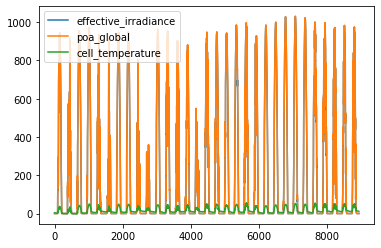

In [30]:
# We can quickly create a plot of the results data using matplotlib
# and pandas. Here we're using a Pandas provided convenience wrapper
# to plot all of a Dataframe's columns with Dataframe.plot()
import matplotlib.pyplot as plt
plt.close("all")
df.plot()

In [35]:
# Monthly summary results include total energy, plane of array
# insolation, effective insolation and average daytime cell
# temperature.
summary_csv_request = requests.get(
    AUDIENCE + f"/jobs/{job_id}/results/9f949415-b4d0-11eb-80ba-569761ad8884",
    headers={
        "Authorization": f"Bearer {token}",
        "Accept": "text/csv",
    }
)
summary_df = pd.read_csv(StringIO(summary_csv_request.text))
summary_df

,month,total_energy,plane_of_array_insolation,effective_insolation,average_daytime_cell_temperature
0,January,1670851.0,158304.16,156096.16,30.992966
